In [1]:
# Import the necessary libraries - ok
# Define Environment Class - ok
# Define Motor - ok
# Define 1st Rocket details - ok
# Start the 1st flight - ok
# Get at the final state - ok
# Define 2nd Rocket details - ok... 
# Define "Payload Rocket" details - ok...

# Start the 2nd and 3rd flight at the same time
# Plots everything together

#-----------------
# TO-DO LIST:
# 1. Adding documentation/comments along the notebook
# 2. Understand wether we can run Monte Carlo simulations in this case or not.

#------------------
# Extra:
# Define Payload Class??
# Move Everything together from this notebook inside the utilities module? This would make things easier to use

# Assumptions: Payload will be deployed at apogee, simultaneously with Drogue Parachute

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function, utilities

In [4]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [5]:
Env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

In [6]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Env.setAtmosphericModel(type="Forecast", file="GFS")

Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2022-09-29 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 8.000 km
Forecast Time Period: From  2022-09-27 18:00:00  to  2022-10-13 18:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 2.33 m/s
Surface Wind Direction: 28.68°
Surface Wind Heading: 208.68°
Surface Pressure: 859.84 hPa
Surface Temperature: 291.34 K
Surface Air Density: 1.028 kg/m³
Surface Speed of Sound: 342.17 m/s


Atmospheric Model Plots


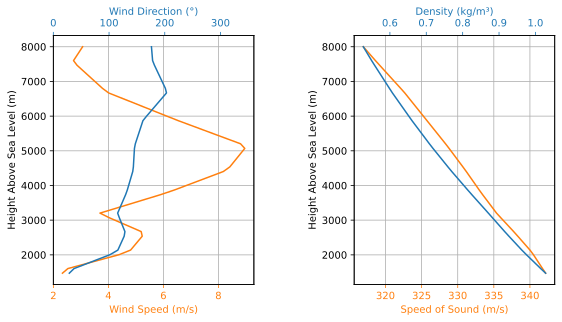

In [7]:
Env.maxExpectedHeight = 8000
Env.info()

## Motor

In [8]:
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)


Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


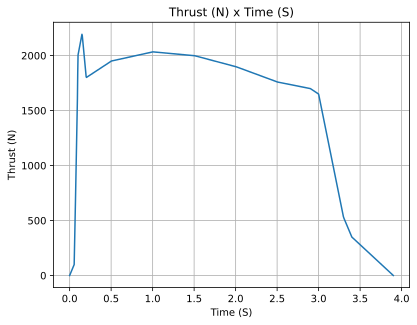

In [9]:
Pro75M1670.info()

## Creating first Rocket

In [22]:
PayloadMass = 4.5
RocketMass = 16.241 - PayloadMass  # 16.241 is the mass of the rocket including the payload but without the propellant

In [23]:
# TODO: Create a "addRocket" and "removeRocket" method to the Flight class
# TODO: Create a "addPayload" and "removePayload" method to the Flight class
# TODO: Option b is to create a "createRocketByMass" and call it twice

In [24]:
Rocket1 = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass= RocketMass+PayloadMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Rocket1.setRailButtons([0.2, -0.5])

NoseCone = Rocket1.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Rocket1.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail = Rocket1.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

## Simulate the first flight

In [25]:
RocketFlight1 = Flight(rocket=Rocket1, 
                    environment=Env, 
                    inclination=85, 
                    heading=0, 
                    terminateOnApogee=True)

In [26]:
Rocket2 = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass= RocketMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag=1,
    powerOnDrag=1,
)

def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False

Main = Rocket2.addParachute(
    "Main",
    CdS= 7.2,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = Rocket2.addParachute(
    "Drogue",
    CdS=0.72,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Rocket2.setRailButtons([0.2, -0.5])

In [27]:
# Rocket2 definition:

RocketFlight2 = Flight(
            rocket=Rocket2,
            environment=Env,
            inclination=0,
            heading=0,
            maxTime=600,
            initialSolution=RocketFlight1,
            )

In [28]:
# Define the Payload Rocket

PayloadRocket = Rocket(motor=Pro75M1670,
                          radius=127 / 2000,
                            mass=PayloadMass,
                            inertiaI=6.60,
                            inertiaZ=0.0351,
                            distanceRocketNozzle=-1.255,
                            distanceRocketPropellant=-0.85704,
                            powerOffDrag=0.5,
                            powerOnDrag=0.5,
                            )

# PayloadRocket.setRailButtons([0.2, -0.5])

def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False

PayloadDrogue = PayloadRocket.addParachute(
    "Drogue",
    CdS=0.35,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

PayloadMain = PayloadRocket.addParachute(
    "Main",
    CdS= 4.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

In [29]:
PayloadFlight = Flight(rocket=PayloadRocket,
                       environment=Env,
                       inclination=0,
                       heading=0,
                       maxTime=600,
                       initialSolution=RocketFlight1,
            )

In [30]:
# Plots Everything together

In [33]:
utilities.compareFlightTrajectories(flight_list=[RocketFlight1, RocketFlight2, PayloadFlight],
                                    names=["Rocket - 1st Stage", "Rocket - 2nd Stage", "Payload"],
                                    )

ValueError: array must not contain infs or NaNs

In [ ]:
# Exports Everything to a .kml file
### Well... This is going to be a pain challenge, but I think I can do it.
### Different flights will be different colors
